# Rodrigo Mendoza TCOR

In [20]:
def get_texts_from_file(path_corpus, path_truth):

    tr_txt = [] # Aqui van los twits
    tr_y = [] # Aqui van las etiquetas

    with open(path_corpus, 'r', encoding='utf-8') as f_corpus, open(path_truth , 'r', encoding='utf-8') as f_truth:
        
        for twitt in f_corpus:
            tr_txt += [twitt]
            
        for label in f_truth:
            tr_y += [label]
    
    return tr_txt,tr_y        

In [21]:
from pathlib import Path
base  = Path.cwd().parent
path_corpus = base / 'Datos y Scripts-20250828' / 'mex20_train.txt'
path_truth = base / 'Datos y Scripts-20250828' / 'mex20_train_labels.txt'
tr_txt, tr_y = get_texts_from_file(path_corpus,path_truth)

# Tokenizacion

In [22]:
from nltk.tokenize import TweetTokenizer
import nltk
tokenizer = TweetTokenizer()
corpus_de_palabras = []

for doc in tr_txt:
    corpus_de_palabras += tokenizer.tokenize(doc)
    
fdist = nltk.FreqDist(corpus_de_palabras)

In [24]:
len(corpus_de_palabras)

97473

In [25]:
def sortFreqDist(freqDist):
    aux = [(freqDist[key], key) for key in freqDist]
    aux.sort()
    aux.reverse()
    return aux
V = sortFreqDist(fdist) # [frecuencia, palabra]
V = V[:5000]
V


[(3016, ','),
 (2915, 'de'),
 (2829, 'que'),
 (2604, '.'),
 (2031, 'la'),
 (1956, 'a'),
 (1856, 'y'),
 (1435, '!'),
 (1430, 'no'),
 (1399, '@USUARIO'),
 (1198, 'me'),
 (1043, 'el'),
 (1018, 'en'),
 (851, 'se'),
 (736, 'es'),
 (706, 'con'),
 (704, '?'),
 (691, 'verga'),
 (683, 'los'),
 (665, 'madre'),
 (612, 'por'),
 (601, 'las'),
 (590, '"'),
 (582, 'un'),
 (550, 'te'),
 (547, 'mi'),
 (509, 'lo'),
 (493, 'putas'),
 (472, 'una'),
 (464, '...'),
 (462, 'putos'),
 (458, 'para'),
 (434, '😂'),
 (422, 'si'),
 (420, 'ya'),
 (416, 'como'),
 (403, 'su'),
 (377, 'pero'),
 (365, 'tu'),
 (357, 'loca'),
 (350, 'le'),
 (325, 'más'),
 (318, 'No'),
 (298, 'del'),
 (294, 'gorda'),
 (284, 'al'),
 (252, 'bien'),
 (249, 'A'),
 (243, '¿'),
 (242, 'Y'),
 (229, 'son'),
 (229, 'Me'),
 (227, 'o'),
 (225, 'feas'),
 (225, 'cuando'),
 (214, 'Que'),
 (208, ':'),
 (205, 'yo'),
 (199, 'les'),
 (196, 'porque'),
 (191, 'ni'),
 (191, 'está'),
 (189, 'ser'),
 (184, 'estoy'),
 (181, 'sus'),
 (172, 'todos'),
 (169, 'esta'

In [26]:
dict_indices = dict()

cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1

In [27]:
# Que ponga la frecuencia en lugar de binario
import numpy as np
def built_bow_tr(tr_txt, vocabulario, dict_indices):
    # Objetivo: Construir la matriz de bow
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=int)
    cont_doc = 0
    # Rellenar la matriz, cada renglon es un twitt y cada renglon una palabra
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc +=1
    return bow
    

In [28]:
bow_tr = built_bow_tr(tr_txt, V, dict_indices)
bow_tr

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], shape=(5278, 5000))

In [29]:
bow_tr.shape

(5278, 5000)

# Construir matriz de cocurrencia de termino vs termino

In [30]:
def compute_tcor(BOW):
    
    DTR = np.zeros((BOW.shape[1], BOW.shape[1]), dtype=np.float64)
    
    print('La matriz de termino por termino es de: ', DTR.shape)
    print('La matriz de Documento por termino es de: ', BOW.shape)
    
    # Recorrer mejor primero cada documento en su representacion BOW
    for doc, i in zip(BOW, range(len(BOW))):
        nonzero_positions = np.nonzero(doc)[0]
        for t1 in nonzero_positions:
            for t2 in nonzero_positions:
                DTR[t1,t2] += 1.0
    V_size = BOW.shape[1]
    W = []
    for index_word in range(V_size):
        co_occurrences = float(np.size(np.where(DTR[index_word,:] > 0), axis=1))
        if co_occurrences > 0:
            W += [V_size/co_occurrences]
        else:
            W += [1]
    W = np.array(W).reshape(1,V_size)
 
    DTR[np.where(DTR > 0)] = (1 + np.log10(DTR[np.where(DTR > 0)]))  
    DTR = DTR * np.log10(W)
    return DTR # Distribucional Term Representation (Embedding distrucional)

In [31]:
from sklearn import preprocessing

In [32]:
TCOR_base = compute_tcor(bow_tr)
TCOR_base = preprocessing.normalize(TCOR_base, norm = 'l2')


La matriz de termino por termino es de:  (5000, 5000)
La matriz de Documento por termino es de:  (5278, 5000)


In [33]:
from sklearn.feature_selection import SelectKBest, chi2
feats = SelectKBest(chi2, k=1000)
feats.fit(bow_tr, tr_y)

,"score_func score_func: callable, default=f_classifFunction taking two arrays X and y, and returning a pair of arrays(scores, pvalues) or a single array with scores.Default is f_classif (see below ""See Also""). The default function onlyworks with classification tasks... versionadded:: 0.18",<function chi...001BA8A29A8E0>
,"k k: int or ""all"", default=10Number of top features to select.The ""all"" option bypasses selection, for use in a parameter search.",1000


In [34]:
best = feats.get_support(indices=True)
best

array([   0,    1,    2,    4,    5,    7,    9,   10,   11,   12,   13,
         17,   18,   19,   22,   24,   25,   28,   30,   32,   35,   36,
         37,   38,   39,   41,   43,   44,   47,   48,   49,   50,   51,
         53,   54,   56,   57,   58,   59,   61,   63,   64,   65,   66,
         67,   69,   70,   71,   74,   78,   79,   85,   86,   87,   88,
         89,   92,   93,   94,   97,  100,  102,  103,  104,  105,  107,
        108,  109,  110,  111,  114,  115,  116,  117,  118,  119,  120,
        122,  123,  124,  125,  128,  129,  131,  133,  134,  135,  136,
        140,  143,  147,  148,  150,  151,  153,  154,  155,  157,  160,
        162,  163,  164,  166,  167,  170,  177,  178,  179,  181,  182,
        184,  185,  186,  187,  188,  191,  192,  193,  200,  201,  207,
        209,  211,  216,  217,  221,  222,  225,  230,  231,  233,  235,
        236,  237,  239,  240,  243,  245,  246,  248,  249,  250,  252,
        253,  256,  257,  258,  259,  260,  264,  2

In [35]:
dict_indices_alreves = {}
for palabra, indice in dict_indices.items():
    dict_indices_alreves[indice] = palabra
dict_indices_alreves

{0: ',',
 1: 'de',
 2: 'que',
 3: '.',
 4: 'la',
 5: 'a',
 6: 'y',
 7: '!',
 8: 'no',
 9: '@USUARIO',
 10: 'me',
 11: 'el',
 12: 'en',
 13: 'se',
 14: 'es',
 15: 'con',
 16: '?',
 17: 'verga',
 18: 'los',
 19: 'madre',
 20: 'por',
 21: 'las',
 22: '"',
 23: 'un',
 24: 'te',
 25: 'mi',
 26: 'lo',
 27: 'putas',
 28: 'una',
 29: '...',
 30: 'putos',
 31: 'para',
 32: '😂',
 33: 'si',
 34: 'ya',
 35: 'como',
 36: 'su',
 37: 'pero',
 38: 'tu',
 39: 'loca',
 40: 'le',
 41: 'más',
 42: 'No',
 43: 'del',
 44: 'gorda',
 45: 'al',
 46: 'bien',
 47: 'A',
 48: '¿',
 49: 'Y',
 50: 'son',
 51: 'Me',
 52: 'o',
 53: 'feas',
 54: 'cuando',
 55: 'Que',
 56: ':',
 57: 'yo',
 58: 'les',
 59: 'porque',
 60: 'ni',
 61: 'está',
 62: 'ser',
 63: 'estoy',
 64: 'sus',
 65: 'todos',
 66: 'esta',
 67: 'puta',
 68: 'Ya',
 69: 'todo',
 70: 'pinche',
 71: 'puto',
 72: 'tan',
 73: 'Si',
 74: 'La',
 75: 'qué',
 76: '…',
 77: 'eso',
 78: 'muy',
 79: 'soy',
 80: 'hasta',
 81: 'así',
 82: '¡',
 83: '<URL>',
 84: 'mamar',


In [36]:
target_word = [dict_indices_alreves[index] for index in best]
t_words = target_word
t_words

[',',
 'de',
 'que',
 'la',
 'a',
 '!',
 '@USUARIO',
 'me',
 'el',
 'en',
 'se',
 'verga',
 'los',
 'madre',
 '"',
 'te',
 'mi',
 'una',
 'putos',
 '😂',
 'como',
 'su',
 'pero',
 'tu',
 'loca',
 'más',
 'del',
 'gorda',
 'A',
 '¿',
 'Y',
 'son',
 'Me',
 'feas',
 'cuando',
 ':',
 'yo',
 'les',
 'porque',
 'está',
 'estoy',
 'sus',
 'todos',
 'esta',
 'puta',
 'todo',
 'pinche',
 'puto',
 'La',
 'muy',
 'soy',
 'hay',
 'q',
 'DE',
 'mis',
 'joto',
 'cosas',
 '️',
 'vida',
 'mejor',
 'vale',
 'quiero',
 'marica',
 'eres',
 'día',
 'esa',
 'voy',
 'gente',
 'Yo',
 '😭',
 'mierda',
 '-',
 'tengo',
 '(',
 'sin',
 'ese',
 ')',
 'luchona',
 '😍',
 'hdp',
 'ahora',
 '“',
 'tienen',
 'pinches',
 'tus',
 'tontas',
 'LA',
 '”',
 'HDP',
 'hoy',
 'cagado',
 'tonta',
 'puedo',
 'mas',
 'pendejo',
 'hijo',
 'NO',
 'Mi',
 'QUE',
 'Lo',
 'algo',
 'PUTOS',
 'alguien',
 'Putos',
 'cabrona',
 'maricon',
 'vas',
 'mucho',
 'MADRE',
 '❤',
 'sé',
 'Estoy',
 'Cuando',
 ';',
 'sí',
 'años',
 'Verga',
 'PUTAS',
 '

In [37]:
# dict_indices {palabra : dimension_en_bow}
target_word = [dict_indices_alreves[index] for index in best]
t_words = target_word
words = [word for word in t_words if word in dict_indices]
target_matrix = np.array([TCOR_base[dict_indices[word]] for word in words])
target_matrix.shape

(1000, 5000)

In [38]:
from sklearn.manifold import TSNE
 
 
reduce_matrix = TSNE(n_components=2).fit_transform(target_matrix)

In [39]:
max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)


print(f"max_x: {max_x}, max_y: {max_y}")
print(f"min_x: {min_x}, min_y: {min_y}")

max_x: 46.824283599853516, max_y: 52.18824005126953
min_x: -41.780029296875, min_y: -44.59942626953125


C:\Users\Rodrigo\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:96: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Rodrigo\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:96: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Rodrigo\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:96: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Rodrigo\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:96: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\Rodrigo\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:96: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\R

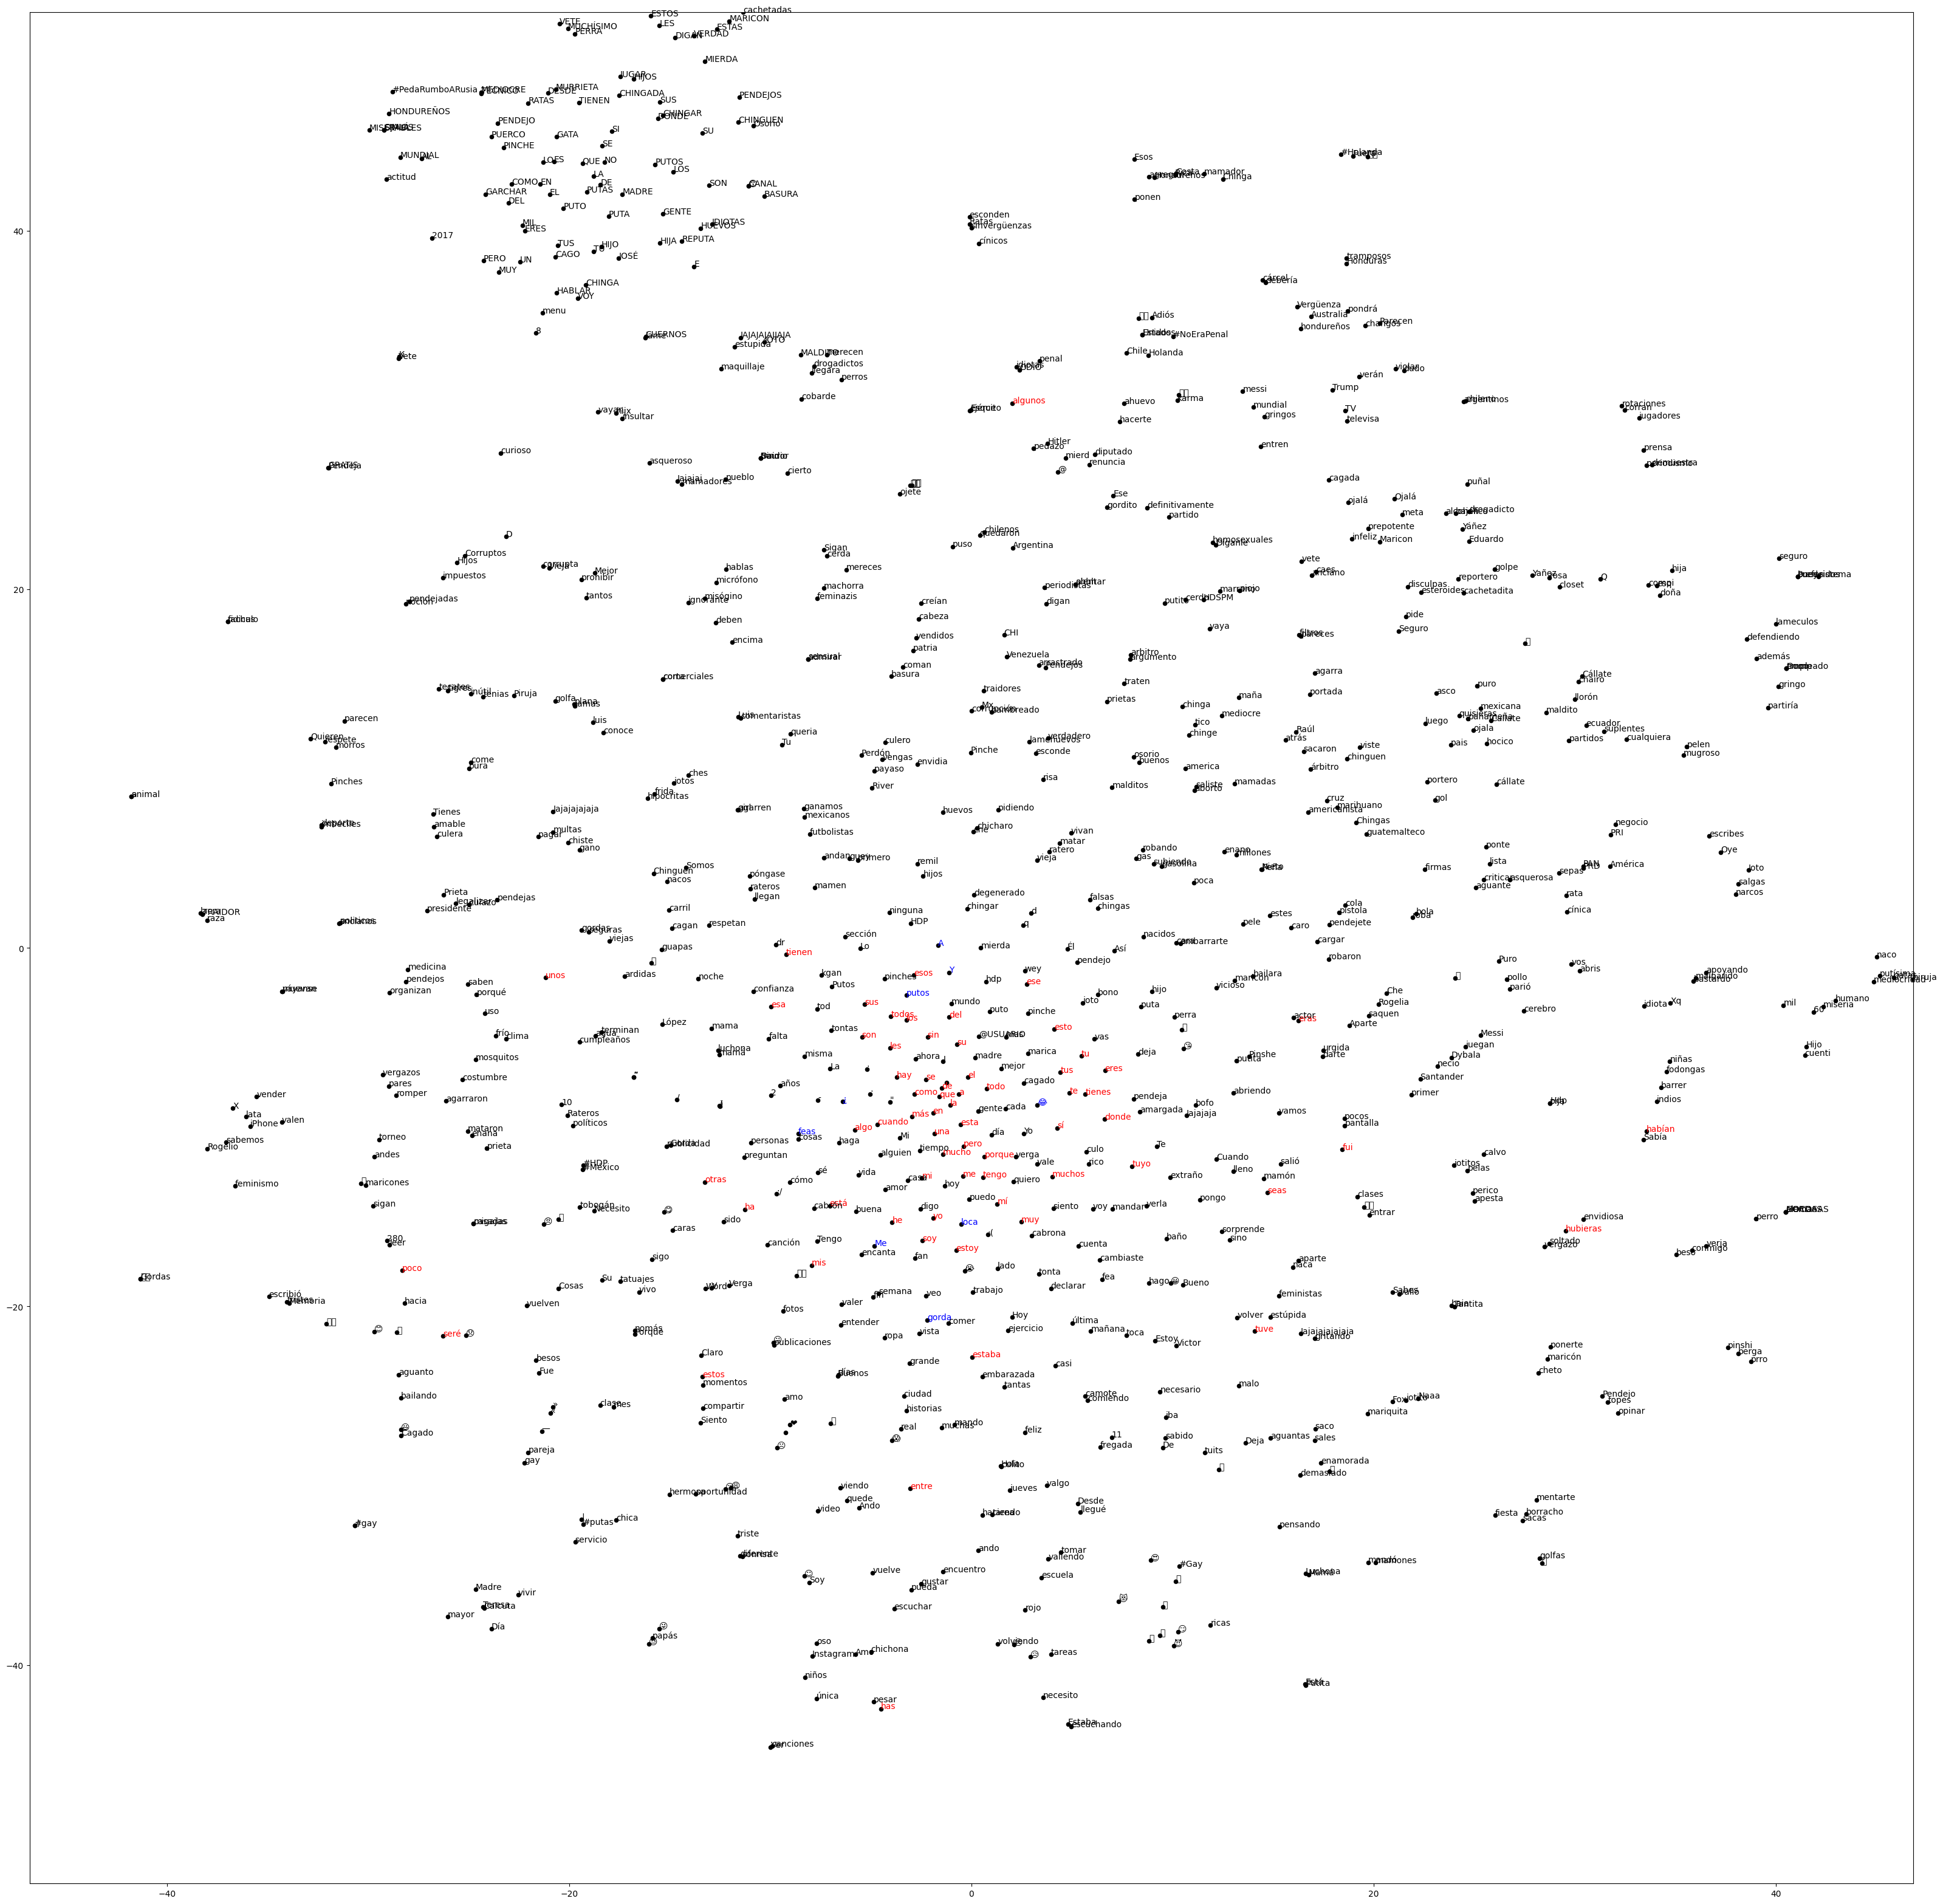

In [40]:
import matplotlib.pyplot as plt
max_x = np.amax(reduce_matrix, axis=0)[0]
max_y = np.amax(reduce_matrix, axis=0)[1]
plt.figure(figsize=(40,40), dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))

plt.scatter(reduce_matrix[:, 0], reduce_matrix[:, 1], 20, color='black')

from nltk.corpus import stopwords
sw = set(stopwords.words('spanish'))

# Agregar una lista de 20 palabras que eliga y poner de otro color (azul)
highlight_words = t_words[15:35]

for idx, word in enumerate(t_words[:]):
    x = reduce_matrix[idx, 0]
    y = reduce_matrix[idx, 1]

    if word in sw:  
        plt.annotate(word, (x, y), color='red')
    elif word in highlight_words:  
        plt.annotate(word, (x, y), color='blue')
    else:  
        plt.annotate(word, (x, y), color='black')
    

# Comentario personal
La principal diferencia que noto es que en TCOR se generan mas subgrupos que en la de DOR, me imagino que se debe a que en la de TCOR se calculan la relacion de las palabras entre si. Para poner un ejemplo, en la de TCOR la palabra mundial esta rodeada de Messi, gringos, #No era penal, Chile; palabras que hacen mas sentido con Mundial. Mientras que, en el DOR cerca de mundial salen palabras que no tienen tanta correlacion.
